<a href="https://colab.research.google.com/github/koya-namba/PyTorch_practice/blob/main/CNN%E3%81%AB%E3%82%88%E3%82%8B%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNによるクラス分類

CNNの代表例は，VGG16である．

画像系の学習ではほぼ必須．

チャネル数だけフィルターがあり，それを学習．

## ライブラリのインポート

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## デバイスの確認

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## データの前処理

transforms.Normalizeは，チャネルごとに平均を0．5，標準偏差を0．5に正規化してくれる．

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

検証用データでは，trainをFalseに設定する

In [6]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### CIFAR10のデータの確認

In [8]:
names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### ミニバッチの用意

検証用データでは，シャッフルの必要がない．

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

### CIFAR10の中身を見てみる

In [12]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()
labels

tensor([9, 4, 9, 3, 6, 6, 3, 1, 3, 4, 7, 9, 6, 0, 6, 0, 6, 3, 7, 4, 6, 8, 1, 3,
        8, 3, 4, 5, 3, 0, 3, 1])

In [13]:
imgs.size()

torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


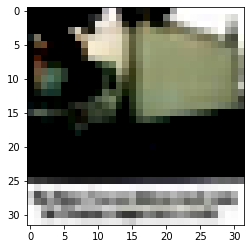

In [18]:
img = imgs[0]
img_permute = img.permute(1, 2, 0)
plt.imshow(img_permute)

以下の処理は，画像の明るさを調整するために行われる．

In [15]:
img_permute = 0.5 * img_permute + 0.5

0から1の間でクリップをおこなう

In [16]:
img_permute = np.clip(img_permute, 0, 1)

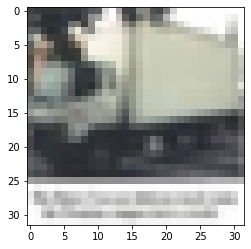

In [17]:
plt.imshow(img_permute)

## モデルの構築

__init__の中には，CNN層と全結合層の2つを定義する．

CNNでは，カーネルサイズに合わせて，パディングの値を設定する必要がある．

あと，注意すべきは全結合層の入力の数と出力の数である．

featuresで帰ってきた値の次元を直すために，x.view(x.size(0), -1)を行い，バッチサイズ×それ以外としている

In [27]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 学習・検証


In [28]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

weight_decayはL2正則化（過学習を抑制するために用いる）

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

それぞれの変数名をつけるときは，バグが起きないように検証用にはvalをつける．

流れ自体は，MLPと変わらない．

In [34]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc +=torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print('epoch: {}, loss: {}, acc: {},\t val_loss: {}, val_acc: {}'.format(
        epoch, running_loss, running_acc, val_running_loss, val_running_acc))
    

epoch: 0, loss: 0.6244468450002845, acc: 0.7814299464225769,	 val_loss: 0.7037990489325965, val_acc: 0.7562898993492126
epoch: 1, loss: 0.5427096678481526, acc: 0.8105806112289429,	 val_loss: 0.7108528276030629, val_acc: 0.7619808316230774
epoch: 2, loss: 0.47785020351257373, acc: 0.8329334855079651,	 val_loss: 0.7237054678959588, val_acc: 0.7589856386184692
epoch: 3, loss: 0.42518757248889616, acc: 0.8512876033782959,	 val_loss: 0.7001002652290911, val_acc: 0.7674720287322998
epoch: 4, loss: 0.3789974227595314, acc: 0.8660228848457336,	 val_loss: 0.7965761968693413, val_acc: 0.7584863901138306
epoch: 5, loss: 0.33919859146049824, acc: 0.8812580108642578,	 val_loss: 0.7678438983976651, val_acc: 0.7667731642723083
epoch: 6, loss: 0.3115634946742465, acc: 0.8892554640769958,	 val_loss: 0.77486757691295, val_acc: 0.7607827186584473
epoch: 7, loss: 0.28313741730841896, acc: 0.899472177028656,	 val_loss: 0.8767121000983082, val_acc: 0.75
epoch: 8, loss: 0.2667921387119146, acc: 0.9065299034

訓練データについては，損失が下がり，精度が上がっている．

しかし，検証用データの精度がよくない．

図示してみる．

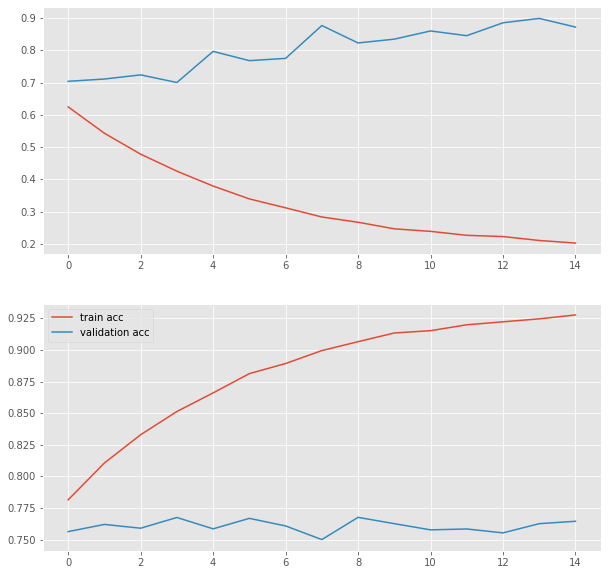

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')

plt.subplot(2, 1, 2)
plt.plot(accs, label='train acc')
plt.plot(val_accs, label='validation acc')

plt.legend()

## データ拡張

データ数を増やすために，画像を増やす．

- ランダムに左右逆転
- ランダムに画像を回転
- ランダムに明るさを変更

transformsに組み込むだけでデータを拡張できる．

- transforms.RandomHorizontalFlip()
- transforms.RandomRotation(10)
- transforms.ColorJitter()

注意点としては，データの数は物理的に増えるわけではなく，DataLoaderからロード時にランダムに操作を実施している．


In [ ]:
val_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

上記のコードを実装して，データをダウンロードする際の引数に気をつければ実装できる．

## まとめ

データ拡張を行なったまとめを行う．

### ライブラリのインポート

In [38]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### デバイスの確認

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### データの前処理

In [41]:
val_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### モデルの構築

In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 学習と検証

In [43]:
model = CNN(10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [44]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc +=torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print('epoch: {}, loss: {}, acc: {},\t val_loss: {}, val_acc: {}'.format(
        epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.422562498239394, acc: 0.4834253191947937,	 val_loss: 1.1747406863937744, val_acc: 0.5817691683769226
epoch: 1, loss: 1.0164092617468123, acc: 0.6413747668266296,	 val_loss: 0.8762884301880297, val_acc: 0.6844049692153931
epoch: 2, loss: 0.8577898570306013, acc: 0.6985364556312561,	 val_loss: 0.7974392326114277, val_acc: 0.7243410348892212
epoch: 3, loss: 0.7753072473305734, acc: 0.7291266918182373,	 val_loss: 0.719657045631363, val_acc: 0.7456070184707642
epoch: 4, loss: 0.7243426463406435, acc: 0.7465011477470398,	 val_loss: 0.725882036379351, val_acc: 0.7520966529846191
epoch: 5, loss: 0.6861540143469245, acc: 0.7597368955612183,	 val_loss: 0.697082232267331, val_acc: 0.7646765112876892
epoch: 6, loss: 0.6531621308393075, acc: 0.7741722464561462,	 val_loss: 0.702704975970637, val_acc: 0.7619808316230774
epoch: 7, loss: 0.6285160482311126, acc: 0.7798304557800293,	 val_loss: 0.6377547552791266, val_acc: 0.7817491888999939
epoch: 8, loss: 0.6098287714381898, acc: 0.78

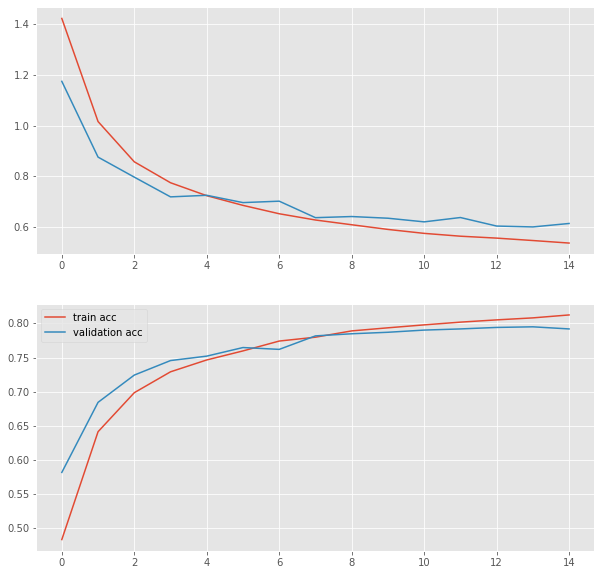

In [45]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')

plt.subplot(2, 1, 2)
plt.plot(accs, label='train acc')
plt.plot(val_accs, label='validation acc')

plt.legend()